# HW1
## Python Code

d:\AppGallery\Anaconda\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1/70, training loss: 49.58712718963623
epoch 1/70, validation loss: 43.64900100708008
epoch 2/70, training loss: 37.05668441772461
epoch 2/70, validation loss: 32.76721946716309
epoch 3/70, training loss: 27.798989639282226
epoch 3/70, validation loss: 24.73687026977539
epoch 4/70, training loss: 20.98874454498291
epoch 4/70, validation loss: 18.816725540161134
epoch 5/70, training loss: 15.96778907775879
epoch 5/70, validation loss: 14.451130294799805
epoch 6/70, training loss: 12.233454189300538
epoch 6/70, validation loss: 11.227638435363769
epoch 7/70, training loss: 9.512199578285218
epoch 7/70, validation loss: 8.850203437805176
epoch 8/70, training loss: 7.522126836776733
epoch 8/70, validation loss: 7.096566276550293
epoch 9/70, training loss: 6.028754379749298
epoch 9/70, validation loss: 5.8001178359985355
epoch 10/70, training loss: 4.912754945755005
epoch 10/70, validation loss: 4.841485471725464
epoch 11/70, training loss: 4.11667984008789
epoch 11/70, validation los

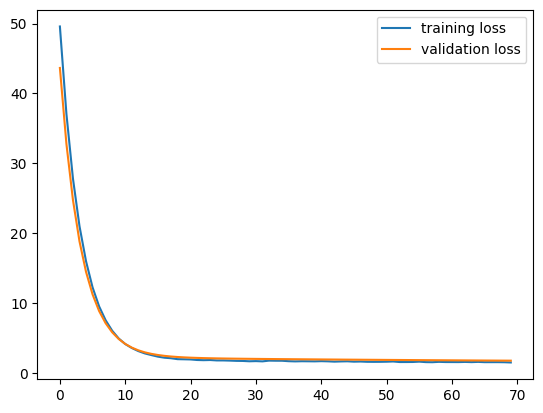

In [1]:
import torch
from torch.utils.data import random_split,DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, N, w1_ref, w2_ref, b_ref, *args, **kwargs):
        super().__init__(*args,**kwargs)
        self.w1_ref = w1_ref
        self.w2_ref = w2_ref
        self.b_ref = b_ref
        self.x_1 = torch.rand(N)
        self.x_2 = torch.rand(N)
        self.noise = torch.randn(N)*0.2
        self.y = w1_ref * self.x_1 + w2_ref * self.x_2 + b_ref + self.noise
        
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return {'input1':self.x_1[idx], 'input2':self.x_2[idx], 'target':self.y[idx]}
    
class LinearRegression(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(in_features=2, out_features=1, bias=True)
    def forward(self, x):
        x = self.fc1(x)
        return x
    
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    mydataset = MyDataset(N=1000, w1_ref=2, w2_ref=3, b_ref=5)
    train_size = int(0.8 * len(mydataset))
    val_size = len(mydataset) - train_size
    train_dataset,val_dataset = random_split(mydataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    model = LinearRegression()
    nn.init.normal_(model.fc1.weight, mean=0.0, std=0.01)
    nn.init.zeros_(model.fc1.bias)
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0005)
    epochs = 70
    training_loss_list = []
    validation_loss_list = []
    for i in range(epochs):
        model.train()
        training_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            input1 = batch['input1'].to(device)
            input2 = batch['input2'].to(device)
            target = batch['target'].to(device)
            input = torch.stack([input1, input2], dim=1)
            prediction = model(input)
            loss = criterion(prediction, target)
            training_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f'epoch {i+1}/{epochs}, training loss: {training_loss/len(train_loader)}')
        training_loss_list.append(training_loss/len(train_loader))
        
        model.eval()
        total_loss = 0.0
        for batch in val_loader:
            input1 = batch['input1'].to(device)
            input2 = batch['input2'].to(device)
            target = batch['target'].to(device)
            input = torch.stack([input1, input2], dim=1)
            with torch.no_grad():
                prediction = model(input)
                loss = criterion(prediction, target)
            total_loss += loss.cpu().item() * len(input)

        print(f'epoch {i+1}/{epochs}, validation loss: {total_loss/len(val_dataset)}')
        validation_loss_list.append(total_loss/len(val_dataset))
    
    print(f"w1:{model.fc1.weight[0][0].item()}, w2:{model.fc1.weight[0][1].item()}, b:{model.fc1.bias.item()}")
    y_true = []
    y_pred = []
    for batch in val_loader:
        input1 = batch['input1'].to(device)
        input2 = batch['input2'].to(device)
        target = batch['target'].to(device)
        input = torch.stack([input1, input2], dim=1)
        with torch.no_grad():
            prediction = model(input)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(prediction.cpu().numpy())
    r2 = r2_score(y_true, y_pred)
    print(f"R²值: {r2:.4f}")
    
    plt.plot(training_loss_list)
    plt.plot(validation_loss_list)
    plt.legend(['training loss', 'validation loss'])
    plt.show()

            



## Analysis

### Dataset
The dataset is generated by the formula:
$$y = w_{1ref}*x_1 + w_{2ref}*x_2 + b_{ref} + noise$$
The noise is generated by: `self.noise = torch.randn(N)*0.2`
And the x_1 and x_2 are generated by:`self.x1 = torch.rand(N)` and `self.x2 = torch.rand(N)`
In general, the dataset is a 2D plane with N points, mixed with gaussian noise.

After the creation of the dataset, dataloder is used to load the dataset in batches, with 20% of the dataset as the validation set and 80% of the dataset as the training set. The batch size is 8, which comes from trying different batch sizes and finding the best one.

The critical parameters are:
- N: 1000
- batch size: 8

### Model
The model is a linear regression model with 2 inputs and 1 output. It is simple, with only one linear layer.
The hyperparameters are:
- learning rate: 0.0005
- number of epochs: 70

### Loss Function
The loss function is the mean squared error loss function. It is used to calculate the loss between the predicted output and the actual output. 
From the diagram, we can see that the loss is decreasing as the number of epochs increases, and it stabilizes at about 20 epochs, but still decreases slightly.
We calculated training loss and validation loss for each epoch, and plotted them on the same graph. As we can see, the training loss and validation loss are similar, which means that the model is not overfitting.

### Results
The model gives us the predicted parameters, which are:
- w1: 1.85
- w2: 1.84
- b: 5.56
The actual parameters are:
- w1: 2
- w2: 3
- b: 5
As we can see, the predicted parameters are not that close to the actual parameters.
So we use $R^2$ to calculate the goodness of fit.
The $R^2$ value is 0.8626, which means that the model is good.

## Conclusion
In this project, we used a single layer linear regression model to fit a 2D plane with gaussian noise. By trying different parameters, we enhanced the performance of the model and the $R^2$ value is 0.8626.